# Experiment 01: Airline dataset

In this experiment we use [the airline dataset](http://kt.ijs.si/elena_ikonomovska/data.html) to predict arrival delay. The dataset consists of a large amount of records, containing flight arrival and departure details for all the commercial flights within the USA, from October 1987 to April 2008. Its size is around 116 million records and 5.76 GB of memory.



In [1]:
import os,sys
import numpy as np
import pandas as pd
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, precision_score,
                             recall_score)
from libs.loaders import load_airline
from libs.conversion import convert_cols_categorical_to_numeric, convert_related_cols_categorical_to_numeric
from libs.timer import Timer
from libs.utils import get_number_processors
from libs.notebook_memory_management import start_watching_memory
import pkg_resources
import json
import matplotlib.pylab as plt
import warnings

print("System version: {}".format(sys.version))
print("XGBoost version: {}".format(pkg_resources.get_distribution('xgboost').version))
print("LightGBM version: {}".format(pkg_resources.get_distribution('lightgbm').version))

%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning) 

System version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
XGBoost version: 0.6
LightGBM version: 0.2


In [2]:
start_watching_memory()

In [2] used 9.9258 MiB RAM in 0.29s, total RAM usage 126.18 MiB


# 1) XGBoost vs LightGBM benchmark
In the next section we compare both libraries speed, accuracy and other metrics for the dataset of airline arrival delay. 

### Data loading and management

In [3]:
%%time
df_plane = load_airline()
print(df_plane.shape)

MOUNT_POINT not found in environment. Defaulting to /fileshare
(115069017, 14)
CPU times: user 1min 40s, sys: 14.8 s, total: 1min 55s
Wall time: 4min 39s
In [3] used 21994.3477 MiB RAM in 279.43s, total RAM usage 22120.53 MiB


In [4]:
df_plane.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,SFO,ORD,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,LAX,SFO,337,0,5
2,1987,10,1,4,5,35,HP,351,167,ICT,LAS,987,0,17
3,1987,10,1,4,5,40,DL,251,35,MCO,PBI,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,LAS,ORD,1515,0,17


In [4] used 0.1758 MiB RAM in 0.12s, total RAM usage 22120.71 MiB


The first step is to convert the categorical features to numeric features.

In [5]:
%%time
df_plane_numeric = convert_related_cols_categorical_to_numeric(df_plane, col_list=['Origin','Dest'])
del df_plane

CPU times: user 1min 45s, sys: 8.02 s, total: 1min 53s
Wall time: 1min 51s
In [5] used 5267.6797 MiB RAM in 111.37s, total RAM usage 27388.39 MiB


In [6]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,HP,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,DL,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,4,33,1515,0,17


In [6] used 0.0664 MiB RAM in 0.12s, total RAM usage 27388.45 MiB


In [7]:
%%time
df_plane_numeric = convert_cols_categorical_to_numeric(df_plane_numeric, col_list='UniqueCarrier')


CPU times: user 1min 2s, sys: 8.68 s, total: 1min 10s
Wall time: 1min 9s
In [7] used 12290.7188 MiB RAM in 69.61s, total RAM usage 39679.17 MiB


In [8]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17


In [8] used 0.0039 MiB RAM in 0.12s, total RAM usage 39679.18 MiB


To simplify the pipeline, we are going to set a classification problem where the goal is to classify wheather a flight has arrived delayed or not. For that we need to binarize the variable `ArrDelay`.

If you want to extend this experiment, you can set a regression problem and try to identify the number of minutes of delay a fight has. Both XGBoost and LightGBM have regression classes.

In [9]:
%%time
df_plane_numeric['ArrDelayBinary'] = 1*(df_plane_numeric['ArrDelay'] > 0)

CPU times: user 516 ms, sys: 468 ms, total: 984 ms
Wall time: 638 ms
In [9] used 877.9258 MiB RAM in 0.74s, total RAM usage 40557.10 MiB


In [10]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay,ArrDelayBinary
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27,1
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5,1
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17,1
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2,0
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17,1


In [10] used 0.0000 MiB RAM in 0.12s, total RAM usage 40557.10 MiB


Once the features are prepared, let's split the dataset into train, validation and test set.

In [11]:
def split_train_val_test_df(df, val_size=0.2, test_size=0.2):
    train, validate, test = np.split(df.sample(frac=1), 
                                     [int((1-val_size-test_size)*len(df)), int((1-test_size)*len(df))])
    return train, validate, test

In [11] used 0.0039 MiB RAM in 0.15s, total RAM usage 40557.11 MiB


In [12]:
%%time
train, validate, test = split_train_val_test_df(df_plane_numeric)
print(train.shape)
print(validate.shape)
print(test.shape)

(69041410, 15)
(23013803, 15)
(23013804, 15)
CPU times: user 57.3 s, sys: 38 s, total: 1min 35s
Wall time: 1min 33s
In [12] used 14033.3398 MiB RAM in 93.81s, total RAM usage 54590.45 MiB


In [13]:
def generate_feables(df):
    X = df[df.columns.difference(['ArrDelay', 'ArrDelayBinary'])]
    y = df['ArrDelayBinary']
    return X,y

In [13] used 0.0586 MiB RAM in 0.10s, total RAM usage 54590.50 MiB


In [14]:
%%time
X_train, y_train = generate_feables(train)
X_val, y_val = generate_feables(validate)
X_test, y_test = generate_feables(test)


CPU times: user 2.2 s, sys: 5.61 s, total: 7.81 s
Wall time: 7.89 s
In [14] used 11414.1758 MiB RAM in 8.00s, total RAM usage 66004.68 MiB


In [15]:
del train, validate, test

In [15] used 0.2930 MiB RAM in 0.10s, total RAM usage 66004.97 MiB


### Training 
Now we are going to create two pipelines, one of XGBoost and one for LightGBM. The technology behind both libraries is different, so it is difficult to compare them in the exact same model setting. XGBoost grows the trees depth-wise and controls model complexity with `max_depth`. Instead, LightGBM uses a leaf-wise algorithm and controls the model complexity by `num_leaves`. As a tradeoff, we use XGBoost with `max_depth=8`, which will have max number leaves of 255, and compare it with LightGBM with `num_leaves=255`. 

In [16]:
results_dict = dict()

In [16] used 0.0000 MiB RAM in 0.10s, total RAM usage 66004.97 MiB


In [17]:
number_processors = get_number_processors()
print(number_processors)

20
In [17] used 0.0000 MiB RAM in 0.10s, total RAM usage 66004.97 MiB


Let's start with the XGBoost classifier.

In [18]:
xgb_clf_pipeline = XGBRegressor(max_depth=8,
                                n_estimators=50,
                                min_child_weight=30,
                                learning_rate=0.1,
                                colsample_bytree=0.80,
                                scale_pos_weight=2,
                                gamma=0.1,
                                reg_lambda=1,
                                subsample=1,
                                n_jobs=number_processors,
                                random_state=77)

In [18] used 0.0000 MiB RAM in 0.11s, total RAM usage 66004.97 MiB


In [19]:
with Timer() as t:
    xgb_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, eval_metric='logloss')

In [19] used 17593.5234 MiB RAM in 1375.55s, total RAM usage 83598.50 MiB


In [20]:
results_dict['xgb']={
    'train_time': t.interval
}

In [20] used 0.0000 MiB RAM in 0.10s, total RAM usage 83598.50 MiB


Training XGBoost model with leave-wise growth

In [21]:
xgb_hist_clf_pipeline = XGBRegressor(max_depth=0,
                                    n_estimators=50,
                                    min_child_weight=30,
                                    learning_rate=0.1,
                                    colsample_bytree=0.80,
                                    scale_pos_weight=2,
                                    gamma=0.1,
                                    reg_lambda=1,
                                    subsample=1,
                                    max_leaves=255,
                                    grow_policy='lossguide',
                                    tree_method='hist',
                                    n_jobs=number_processors,
                                    random_state=77)

In [21] used 0.0000 MiB RAM in 0.10s, total RAM usage 83598.50 MiB


In [22]:
with Timer() as t:
    xgb_hist_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, eval_metric='logloss')

In [22] used 20086.5977 MiB RAM in 501.82s, total RAM usage 103685.09 MiB


In [23]:
results_dict['xgb_hist']={
    'train_time': t.interval
}

In [23] used 0.0000 MiB RAM in 0.10s, total RAM usage 103685.09 MiB


Training LightGBM model

In [24]:
lgbm_clf_pipeline = LGBMRegressor(num_leaves=255,
                                  n_estimators=50,
                                  min_child_weight=30,
                                  learning_rate=0.1,
                                  colsample_bytree=0.80,
                                  scale_pos_weight=2,
                                  min_split_gain=0.1,
                                  reg_lambda=1,
                                  subsample=1,
                                  nthread=number_processors,
                                  seed=77)

In [24] used 0.0000 MiB RAM in 0.11s, total RAM usage 103685.09 MiB


In [25]:
def loglikelood(y_true, y_pred):
    eval_result = log_loss(y_true, y_pred)
    eval_name = 'log_loss'
    is_bigger_better = False
    return eval_name, eval_result, is_bigger_better

In [25] used 0.0000 MiB RAM in 0.10s, total RAM usage 103685.09 MiB


In [26]:
with Timer() as t:
    lgbm_clf_pipeline.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, eval_metric=loglikelood)

In [26] used 12366.5508 MiB RAM in 712.98s, total RAM usage 116051.64 MiB


In [27]:
results_dict['lgbm']={
    'train_time': t.interval
}

In [27] used 0.0000 MiB RAM in 0.10s, total RAM usage 116051.64 MiB


As it can be seen in the results, given the specific versions and parameters of both XGBoost and LightGBM and in this specific dataset, LightGBM is faster. 

In general terms, leaf-wise algorithms are more efficient, they converge much faster than depth-wise. However, it may cause over-fitting when the data is small or there are too many leaves.

### Evaluation
Now let's evaluate the model in the test set.

In [28]:
with Timer() as t:
    y_prob_xgb = np.clip(xgb_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [28] used 199.6641 MiB RAM in 12.92s, total RAM usage 116251.31 MiB


In [29]:
results_dict['xgb']['test_time'] = t.interval

In [29] used 0.0000 MiB RAM in 0.10s, total RAM usage 116251.31 MiB


In [30]:
with Timer() as t:
    y_prob_xgb_hist = np.clip(xgb_hist_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [30] used 87.7930 MiB RAM in 14.55s, total RAM usage 116339.10 MiB


In [31]:
results_dict['xgb_hist']['test_time'] = t.interval

In [31] used 0.0000 MiB RAM in 0.10s, total RAM usage 116339.10 MiB


In [32]:
with Timer() as t:
    y_prob_lgbm = np.clip(lgbm_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [32] used 2458.1328 MiB RAM in 16.12s, total RAM usage 118797.23 MiB


In [33]:
results_dict['lgbm']['test_time'] = t.interval


In [33] used 0.0039 MiB RAM in 0.10s, total RAM usage 118797.24 MiB


### Metrics
We are going to obtain some metrics to evaluate the performance of each of the models.

In [34]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary(y_true, y_pred):
    m_acc = accuracy_score(y_true, y_pred)
    m_f1 = f1_score(y_true, y_pred)
    m_precision = precision_score(y_true, y_pred)
    m_recall = recall_score(y_true, y_pred)
    report = {'Accuracy':m_acc, 'Precision':m_precision, 'Recall':m_recall, 'F1':m_f1}
    return report

In [34] used 0.0000 MiB RAM in 0.11s, total RAM usage 118797.24 MiB


In [35]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary_prob(y_true, y_prob):
    m_auc = roc_auc_score(y_true, y_prob)
    report = {'AUC':m_auc}
    return report

In [35] used -11412.7930 MiB RAM in 0.13s, total RAM usage 107384.45 MiB


In [36]:
def binarize_prediction(y, threshold=0.5):
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred

In [36] used 0.0000 MiB RAM in 0.10s, total RAM usage 107384.45 MiB


In [37]:
y_pred_xgb = binarize_prediction(y_prob_xgb)
y_pred_xgb_hist = binarize_prediction(y_prob_xgb_hist)
y_pred_lgbm = binarize_prediction(y_prob_lgbm)


In [37] used 526.6836 MiB RAM in 0.58s, total RAM usage 107911.13 MiB


In [38]:
report_xgb = classification_metrics_binary(y_test, y_pred_xgb)
report2_xgb = classification_metrics_binary_prob(y_test, y_prob_xgb)
report_xgb.update(report2_xgb)

In [38] used 517.9961 MiB RAM in 30.92s, total RAM usage 108429.12 MiB


In [39]:
results_dict['xgb']['performance'] = report_xgb

In [39] used 0.0078 MiB RAM in 0.10s, total RAM usage 108429.13 MiB


In [40]:
report_xgb_hist = classification_metrics_binary(y_test, y_pred_xgb_hist)
report2_xgb_hist = classification_metrics_binary_prob(y_test, y_prob_xgb_hist)
report_xgb_hist.update(report2_xgb_hist)

In [40] used 13.9883 MiB RAM in 25.95s, total RAM usage 108443.12 MiB


In [41]:
results_dict['xgb_hist']['performance'] = report_xgb_hist

In [41] used 0.0000 MiB RAM in 0.10s, total RAM usage 108443.12 MiB


In [42]:
report_lgbm = classification_metrics_binary(y_test, y_pred_lgbm)
report2_lgbm = classification_metrics_binary_prob(y_test, y_prob_lgbm)
report_lgbm.update(report2_lgbm)

In [42] used 0.0000 MiB RAM in 27.21s, total RAM usage 108443.12 MiB


In [43]:
results_dict['lgbm']['performance'] = report_lgbm

In [43] used 0.0000 MiB RAM in 0.10s, total RAM usage 108443.12 MiB


In [44]:
# Results
print(json.dumps(results_dict, indent=4, sort_keys=True))

{
    "lgbm": {
        "performance": {
            "AUC": 0.809088755748925,
            "Accuracy": 0.7355849558812615,
            "F1": 0.6941587253529274,
            "Precision": 0.7696994015226369,
            "Recall": 0.6321204703456322
        },
        "test_time": 16.32199591999961,
        "train_time": 726.8936389700029
    },
    "xgb": {
        "performance": {
            "AUC": 0.7853689614202887,
            "Accuracy": 0.6294364026042805,
            "F1": 0.697598625986962,
            "Precision": 0.5693590516759113,
            "Recall": 0.9004002600724765
        },
        "test_time": 13.113098572997842,
        "train_time": 1399.2995487649969
    },
    "xgb_hist": {
        "performance": {
            "AUC": 0.8073979215850341,
            "Accuracy": 0.6728619049679923,
            "F1": 0.7165954832604183,
            "Precision": 0.6085626365802239,
            "Recall": 0.8712633003153328
        },
        "test_time": 14.75591311899916,
        "t

The experiment shows a fairly similar performance in both libraries, being LightGBM slightly better.

In [45]:
del xgb_clf_pipeline, xgb_hist_clf_pipeline, lgbm_clf_pipeline, X_train, X_test, X_val

In [45] used -51018.4648 MiB RAM in 1.27s, total RAM usage 57424.66 MiB


# 2) Concept drift
In this section we are trying to find concept drift in the dataset to check if retraining is valuable.

### Data management
We are going to pack the data yearly to try to find concept drift

In [46]:
def get_data_list_yearly(df):
    data_yearly = [df[df['Year'] == year] for year in range(1987, 2008)]  
    return data_yearly

In [46] used 0.0000 MiB RAM in 0.11s, total RAM usage 57424.66 MiB


In [47]:
%%time
data_yearly_list = get_data_list_yearly(df_plane_numeric)
del(df_plane_numeric)
for subset in data_yearly_list:
    print(subset.shape)

(1287333, 15)
(5126498, 15)
(290827, 15)
(5110527, 15)
(4995005, 15)
(5020651, 15)
(4993587, 15)
(5078411, 15)
(5219140, 15)
(5209326, 15)
(5301999, 15)
(5227051, 15)
(5360018, 15)
(5481303, 15)
(5723673, 15)
(5197860, 15)
(6375689, 15)
(6987729, 15)
(6992838, 15)
(7003802, 15)
(7275288, 15)
CPU times: user 8.7 s, sys: 3.97 s, total: 12.7 s
Wall time: 12.5 s
In [47] used 12753.6445 MiB RAM in 12.56s, total RAM usage 70178.30 MiB


In [48]:
total_subsets = len(data_yearly_list)
print("Number of years: {}".format(total_subsets))
num_ini = 5

Number of years: 21
In [48] used 0.0000 MiB RAM in 0.10s, total RAM usage 70178.30 MiB


In [49]:
def generate_subset(data_yearly_list, num):
    subset = data_yearly_list[0]
    for i in range(1,num):
        subset = pd.concat([subset, data_yearly_list[i]])
    return subset

In [49] used 0.0000 MiB RAM in 0.10s, total RAM usage 70178.30 MiB


### Traininig
Let's see what happens when we train on a subset of data and then evaluate in the data of the following years.

In [50]:
%%time
subset_base = generate_subset(data_yearly_list, num_ini)
print(subset_base.shape)

(16810190, 15)
CPU times: user 864 ms, sys: 1.28 s, total: 2.15 s
Wall time: 2.04 s
In [50] used 2052.0312 MiB RAM in 2.14s, total RAM usage 72230.33 MiB


In [51]:
X_train, y_train = generate_feables(subset_base)
del(subset_base)

In [51] used 1667.0898 MiB RAM in 0.81s, total RAM usage 73897.42 MiB


In [52]:
clf = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [52] used 0.1914 MiB RAM in 0.10s, total RAM usage 73897.61 MiB


In [53]:
%%time
clf.fit(X_train, y_train)

CPU times: user 26min 1s, sys: 26.5 s, total: 26min 28s
Wall time: 1min 21s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=30, min_split_gain=0, n_estimators=100,
        nthread=-1, num_leaves=255, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=42, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [53] used 2324.8203 MiB RAM in 82.12s, total RAM usage 76222.43 MiB


In [54]:
def predict_accuracy_future_years(clf, data_yearly_list, num_ini):
    total_subsets = len(data_yearly_list)
    accuracy_dict = {}
    for y in range(num_ini, total_subsets):
        year = data_yearly_list[y]['Year'].iloc[0]
        print("Predicting year {}...".format(year))
        X_test, y_test = generate_feables(data_yearly_list[y])
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_dict[year] = acc
    return accuracy_dict

In [54] used 0.0000 MiB RAM in 0.11s, total RAM usage 76222.43 MiB


In [55]:
%%time
accuracy_dict = predict_accuracy_future_years(clf, data_yearly_list, num_ini)
print(accuracy_dict)

Predicting year 1992...
Predicting year 1993...
Predicting year 1994...
Predicting year 1995...
Predicting year 1996...
Predicting year 1997...
Predicting year 1998...
Predicting year 1999...
Predicting year 2000...
Predicting year 2001...
Predicting year 2002...
Predicting year 2003...
Predicting year 2004...
Predicting year 2005...
Predicting year 2006...
Predicting year 2007...
{1992: 0.75585058591007426, 1993: 0.75526209916839337, 1994: 0.7434018239169693, 1995: 0.73088401537418046, 1996: 0.72221915080760923, 1997: 0.72038998875707072, 1998: 0.70534666679165747, 1999: 0.70026891700736826, 2000: 0.68913595909585734, 2001: 0.67351401800906519, 2002: 0.67900155063814727, 2003: 0.68467627577192047, 2004: 0.67967690218095178, 2005: 0.67261289336318097, 2006: 0.66322991426656552, 2007: 0.65105340159729763}
CPU times: user 33min 46s, sys: 17.8 s, total: 34min 4s
Wall time: 2min 18s
In [55] used 2825.7539 MiB RAM in 138.67s, total RAM usage 79048.19 MiB


From the results we can observe that the accuracy of the model gets worse as the years pass on.

### Retraining
Now let's see what happens when we retrain and evaluate in the data of the following years.

In [56]:
new_init = 15

In [56] used 0.0000 MiB RAM in 0.10s, total RAM usage 79048.19 MiB


In [57]:
%%time
subset_retrain = generate_subset(data_yearly_list, new_init)
print(subset_retrain.shape)

(69425349, 15)
CPU times: user 11.7 s, sys: 26 s, total: 37.7 s
Wall time: 37 s
In [57] used 8474.7695 MiB RAM in 37.10s, total RAM usage 87522.96 MiB


In [58]:
X_train, y_train = generate_feables(subset_retrain)
del(subset_retrain)

In [58] used 3166.4609 MiB RAM in 2.78s, total RAM usage 90689.42 MiB


In [59]:
clf_retrain = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [59] used 0.0000 MiB RAM in 0.10s, total RAM usage 90689.42 MiB


In [60]:
%%time
clf_retrain.fit(X_train, y_train)

CPU times: user 1h 40min 35s, sys: 1min 19s, total: 1h 41min 54s
Wall time: 5min 17s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=30, min_split_gain=0, n_estimators=100,
        nthread=-1, num_leaves=255, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=42, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [60] used 9798.9961 MiB RAM in 317.98s, total RAM usage 100488.41 MiB


In [61]:
%%time
accuracy_retrain = predict_accuracy_future_years(clf_retrain, data_yearly_list, new_init)
print(accuracy_retrain)

Predicting year 2002...
Predicting year 2003...
Predicting year 2004...
Predicting year 2005...
Predicting year 2006...
Predicting year 2007...
{2002: 0.75116624918716546, 2003: 0.74984397764696487, 2004: 0.72600969499532686, 2005: 0.72041222748188938, 2006: 0.70769504906049596, 2007: 0.69621175134235236}
CPU times: user 12min 55s, sys: 7.54 s, total: 13min 2s
Wall time: 50.9 s
In [61] used 3950.7109 MiB RAM in 51.05s, total RAM usage 104439.12 MiB


### Plot

In [62]:
def plot_metrics(metric1, metric2, legend1=None, legend2=None, x_label=None, y_label=None):
    lists = sorted(metric1.items()) 
    x, y = zip(*lists) 
    fig, ax = plt.subplots()
    ax.plot(x, y, label=legend1, color='#5975a4')
    lists2 = sorted(metric2.items()) 
    x2, y2 = zip(*lists2) 
    ax.plot(x2, y2, label=legend2, color='#5f9e6f')
    legend = ax.legend(loc=0)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()
    return ax

In [62] used 0.0000 MiB RAM in 0.11s, total RAM usage 104439.12 MiB


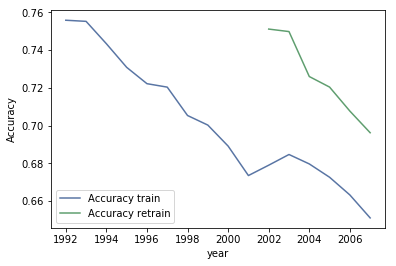

In [63] used -20664.2578 MiB RAM in 1.20s, total RAM usage 83774.87 MiB


In [63]:
# Airline Retrain Results
ax = plot_metrics(accuracy_dict, accuracy_retrain, legend1='Accuracy train', legend2='Accuracy retrain', x_label='year', 
             y_label='Accuracy')
fig = ax.get_figure()
fig.savefig('airline.svg', bbox_inches='tight')

As it can be seen, the performance is better after retraining. We have found concept drift in this dataset.